# Fiducial Marker Study

In [1]:
# Cell 1: Instantiate CARLA world, spawn vehicle, and study spectator viewpoints
# Purpose: Set up the simulation environment, place a vehicle at the first waypoint,
# and cycle through spectator viewpoints around the vehicle for camera placement study.

# Note game engine must be running before executing this script.
# cd /opt/carla-simulator
# ./CarlaUE4.sh

import carla
import time
import logging
import sys
import os

# For Jupyter, use os.getcwd() instead of __file__
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import carla_helpers as helpers

# Configure logging for debugging and LaTeX documentation
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Connect to CARLA server
try:
    client = carla.Client('localhost', 2000)
    client.set_timeout(10.0)
    world = client.get_world()
    logging.info("Connected to CARLA server")
except Exception as e:
    logging.error(f"Failed to connect to CARLA server: {e}")
    raise

# Load Town04 map
try:
    world = client.load_world('Town04')
    logging.info("Loaded Town04 map")
except Exception as e:
    logging.error(f"Failed to load Town04 map: {e}")
    raise

# Get blueprint library
bp_lib = world.get_blueprint_library()

# Select Tesla Model 3 blueprint
vehicle_bp = bp_lib.find('vehicle.tesla.model3')
if not vehicle_bp:
    logging.error("Tesla Model 3 blueprint not found")
    raise ValueError("Tesla Model 3 blueprint not found")

# Get figure-8 waypoints
try:
    waypoints = helpers.get_town04_figure8_waypoints(world, lane_id=-2) # second from left to right
    waypoints_1 = helpers.get_town04_figure8_waypoints(world, lane_id=-1) # first from left to right
    waypoints_2 = waypoints
    waypoints_3 = helpers.get_town04_figure8_waypoints(world, lane_id=-3) # third from left to right
    if not waypoints:
        raise ValueError("No waypoints retrieved")
    logging.info(f"Retrieved {len(waypoints)} figure-8 waypoints")
except Exception as e:
    logging.error(f"Failed to retrieve waypoints: {e}")
    raise

2025-05-12 19:59:47,890 - INFO - Connected to CARLA server
2025-05-12 19:59:50,303 - INFO - Loaded Town04 map
2025-05-12 19:59:52,251 - INFO - Retrieved 3063 figure-8 waypoints


## Spawn vehicle

In [2]:
# Prepare spawn point (first waypoint, adjusted height)
spawn_point = waypoints[0].transform
spawn_point.location.z += 0.6  # Adjust height to avoid ground collision
logging.info(f"Vehicle spawn point: {spawn_point.location}")

# Spawn vehicle
vehicle = world.try_spawn_actor(vehicle_bp, spawn_point)
if not vehicle:
    logging.error("Failed to spawn vehicle")
    raise RuntimeError("Failed to spawn vehicle")
logging.info(f"Vehicle spawned with ID {vehicle.id} at {spawn_point.location}")

2025-05-12 19:59:52,268 - INFO - Vehicle spawn point: Location(x=160.373428, y=-371.640350, z=0.600000)
2025-05-12 19:59:52,283 - INFO - Vehicle spawned with ID 145 at Location(x=160.373428, y=-371.640350, z=0.600000)


## View functions

In [ ]:
def default_view(world, base_transform): # camera view
    import carla_helpers as helpers
    local_transform = base_transform
    local_transform.location.z += 0.35
    local_transform.location.z += 1.4 # need to copy as base_transform is a reference
    helpers.set_spectator_transform(world, local_transform.location, local_transform.rotation)

# Set base transform for views of vehicle

In [5]:
base_transform = vehicle.get_transform()
base_transform.location.z += 0.6

## Default location (camera view)

In [6]:
default_view(world, waypoints[0].transform)


=== Spectator Transform Set ===
Location: x=160.37, y=-371.64, z=1.75
Rotation: pitch=0.00, yaw=0.50, roll=0.00


# Lane segmentation

In [7]:
def draw_permanent_waypoint_lines(world, waypoints, color=carla.Color(0, 255, 0), thickness=2, life_time=0):
    """
    Draw permanent lines linking every waypoint on the road.

    Parameters:
    - world: CARLA world object.
    - waypoints: List of waypoints to link.
    - color: Color of the lines (default is neon green).
    - thickness: Thickness of the lines (default is 0.1 meters).
    """
    for i in range(len(waypoints) - 1):
        # Get the current and next waypoint
        wp1 = waypoints[i]
        wp2 = waypoints[i + 1]

        # Draw a line between the two waypoints
        world.debug.draw_line(
            wp1.transform.location,  # Start point
            wp2.transform.location,  # End point
            thickness=thickness,     # Line thickness
            color=color,             # Line color
            life_time=life_time      # Permanent line (life_time=0 means infinite)
        )

In [8]:
#draw_permanent_waypoint_lines(world, waypoints_1, color=carla.Color(1, 0, 0), thickness=2, life_time=8)
draw_permanent_waypoint_lines(world, waypoints_2, color=carla.Color(35, 35, 0), thickness=1.5, life_time=0)
#draw_permanent_waypoint_lines(world, waypoints_3, color=carla.Color(1, 0, 0), thickness=2, life_time=8)

# Set up camera

In [9]:
import logging
import carla
import numpy as np
import queue
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

def test_vehicle_and_camera(world, vehicle, camera_config):
    """
    Test vehicle and camera setup with a given configuration.

    Args:
        world: CARLA world object.
        vehicle: CARLA vehicle object.
        camera_config: Dict with camera parameters (width, height, fov, position, rotation).
    """
    settings = world.get_settings()
    settings.synchronous_mode = True
    settings.fixed_delta_seconds = 0.05
    world.apply_settings(settings)

    camera = None
    try:
        # Attach camera
        blueprint_library = world.get_blueprint_library()
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", str(camera_config["width"]))
        camera_bp.set_attribute("image_size_y", str(camera_config["height"]))
        camera_bp.set_attribute("fov", str(camera_config["fov"]))

        camera_transform = carla.Transform(camera_config["position"], camera_config["rotation"])
        camera = world.try_spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
        if not camera:
            raise RuntimeError("Failed to spawn camera")

        image_queue = queue.Queue()
        camera.listen(image_queue.put)
        logging.info(f"Camera attached at {camera_transform.location}, rotation {camera_transform.rotation}")

        # Capture image
        for _ in range(10):
            world.tick()
            if not image_queue.empty():
                image = image_queue.get()
                image_array = np.frombuffer(image.raw_data, dtype=np.uint8)
                image_array = image_array.reshape((camera_config["height"], camera_config["width"], 4))[:, :, :3]
                
                # Swap red and blue channels (BGR to RGB)
                image_array = image_array[:, :, [2, 1, 0]]  # Change BGR to RGB by reordering channels
                
                assert image_array.shape == (camera_config["height"], camera_config["width"], 3), \
                    f"Image size mismatch: expected {(camera_config['height'], camera_config['width'], 3)}"
                logging.info("Image captured and verified")

                plt.imshow(image_array)
                plt.axis("off")
                plt.show()
                return

        raise TimeoutError("No image captured after 10 frames")
    finally:
        if camera:
            camera.destroy()
            logging.info("Camera destroyed")
        settings.synchronous_mode = False
        world.apply_settings(settings)

## Camera setup with fiducial markers

In [14]:
import logging
import carla
import numpy as np
import queue
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

def test_vehicle_and_camera_with_fiducial_markers(world, vehicle, camera_config):
    """
    Test vehicle and camera setup with a given configuration, adding fiducial markers to the image.

    Args:
        world: CARLA world object.
        vehicle: CARLA vehicle object.
        camera_config: Dict with camera parameters (width, height, fov, position, rotation).
    """
    settings = world.get_settings()
    settings.synchronous_mode = True
    settings.fixed_delta_seconds = 0.05
    world.apply_settings(settings)

    camera = None
    try:
        # Attach camera
        blueprint_library = world.get_blueprint_library()
        camera_bp = blueprint_library.find("sensor.camera.rgb")
        camera_bp.set_attribute("image_size_x", str(camera_config["width"]))
        camera_bp.set_attribute("image_size_y", str(camera_config["height"]))
        camera_bp.set_attribute("fov", str(camera_config["fov"]))

        camera_transform = carla.Transform(camera_config["position"], camera_config["rotation"])
        camera = world.try_spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
        if not camera:
            raise RuntimeError("Failed to spawn camera")

        image_queue = queue.Queue()
        camera.listen(image_queue.put)
        logging.info(f"Camera attached at {camera_transform.location}, rotation {camera_transform.rotation}")

        # Capture image
        for _ in range(10):
            world.tick()
            if not image_queue.empty():
                image = image_queue.get()
                image_array = np.frombuffer(image.raw_data, dtype=np.uint8)
                image_array = image_array.reshape((camera_config["height"], camera_config["width"], 4))[:, :, :3]
                
                # Swap red and blue channels (BGR to RGB)
                image_array = image_array[:, :, [2, 1, 0]]  # Change BGR to RGB by reordering channels
                
                assert image_array.shape == (camera_config["height"], camera_config["width"], 3), \
                    f"Image size mismatch: expected {(camera_config['height'], camera_config['width'], 3)}"
                logging.info("Image captured and verified")

                # Add fiducial markers
                marker_size = 20
                marker_color = [255, 0, 0]  # Red in RGB
                offset = 90  # Pixels from left/right edges
                bottom_y = camera_config["height"] - marker_size  # Start at bottom of image

                # Left marker (50 pixels from left edge)
                image_array[bottom_y:bottom_y + marker_size, offset:offset + marker_size, :] = marker_color

                # Right marker (50 pixels from right edge)
                right_x = camera_config["width"] - offset - marker_size
                image_array[bottom_y:bottom_y + marker_size, right_x:right_x + marker_size, :] = marker_color

                plt.imshow(image_array)
                plt.axis("off")
                plt.show()
                return

        raise TimeoutError("No image captured after 10 frames")
    finally:
        if camera:
            camera.destroy()
            logging.info("Camera destroyed")
        settings.synchronous_mode = False
        world.apply_settings(settings)

## Fiducial Markers on either side of the lane

2025-05-12 20:04:49,611 - INFO - Camera attached at Location(x=1.500000, y=0.000000, z=1.800000), rotation Rotation(pitch=-5.000000, yaw=0.000000, roll=0.000000)
2025-05-12 20:04:49,689 - INFO - Image captured and verified


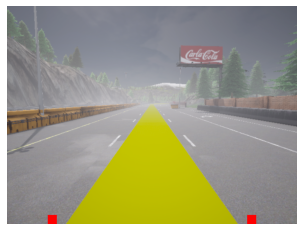

2025-05-12 20:04:49,850 - INFO - Camera destroyed


In [15]:
# Example usage
camera_config = {
    "width": 640,
    "height": 480,
    "fov": 90,
    "position": carla.Location(x=1.5, y=0.0, z=1.8),
    "rotation": carla.Rotation(pitch=-5.0, yaw=0.0, roll=0.0)
}
test_vehicle_and_camera_with_fiducial_markers(world, vehicle, camera_config)

## Fiducial Markers